# Phonon Dispersion
This example is originally from [GPUMD](https://github.com/brucefan1983/GPUMD) and has been added here with minor changes only to demonstrate how to use [gpyumd](https://github.com/AlexGabourie/gpyumd).

## 1. Introduction
- In this example, we use harmonic lattice dynamics to calculate the phonon dispersion of diamond silicon.

### Importing Relevant Functions
- The inputs/outputs for GPUMD are processed using the [Atomic Simulation Environment (ASE)](https://wiki.fysik.dtu.dk/ase/) and the [gpyumd](https://github.com/AlexGabourie/gpyumd) package.

In [1]:
import matplotlib.pyplot as plt
from ase.lattice.cubic import Diamond
from ase.build import bulk
from gpyumd.atoms import GpumdAtoms
from gpyumd.sim import Simulation
import gpyumd.keyword as kwd
from gpyumd.load import load_omega2

## 2. Preparting the Inputs
- The structure as specified is 64-atom diamond silicon at zero temperature and zero pressure. 
- Weuse the minimal Tersoff potential [[Fan 2020]](https://doi.org/10.1088/1361-648X/ab5c5f).

#### Create Si Unit Cell & Add Basis

In [2]:
a=5.434
Si_UC = GpumdAtoms(bulk('Si', 'diamond', a=a))
Si_UC.add_basis()
Si_UC

GpumdAtoms(symbols='Si2', pbc=True, cell=[[0.0, 2.717, 2.717], [2.717, 0.0, 2.717], [2.717, 2.717, 0.0]])

### Generate the  [xyz.in](https://gpumd.zheyongfan.org/index.php/The_xyz.in_input_file) file:
Transform Si to cubic supercell first. Note: We write the <code>xyz.in</code> file here for demonstration purposes, but the Simulation we are about to make also outputs the <code>xyz.in</code> file.

In [3]:
# Create 8 atom diamond structure
Si = Si_UC.repeat([2,2,1])
Si.set_cell([a, a, a])
Si.wrap()

# Complete full supercell
Si = Si.repeat([2,2,2])
Si.set_max_neighbors(4)
Si.set_cutoff(3)
Si.write_gpumd()
Si

GpumdAtoms(symbols='Si64', pbc=True, cell=[10.868, 10.868, 10.868])

### Write [basis.in](https://gpumd.zheyongfan.org/index.php/The_basis.in_input_file) file:

In [4]:
Si.write_basis()

- The [basis.in](https://gpumd.zheyongfan.org/index.php/The_basis.in_input_file) file reads:
```
2
0 28.085
1 28.085
0
1
0
1
0
1
...
```
- Here the primitive cell is chosen as the unit cell. There are only two basis atoms in the unit cell, as indicated by the number 2 in the first line.

- The next two lines list the indices (0 and 1) and masses (both are 28.085 amu) for the two basis atoms.

- The next lines map all the atoms (including the basis atoms) in the super cell to the basis atoms: atoms equivalent to atom 0 have a label 0, and atoms equivalent to atom 1 have a label 1.

### Write [kpoints.in](https://gpumd.zheyongfan.org/index.php/The_kpoints.in_input_file) file:
- The $k$ vectors are defined in the reciprocal space with respect to the unit cell chosen in the [basis.in](https://gpumd.zheyongfan.org/index.php/The_basis.in_input_file) file.
- We use the $\Gamma-X-K-\Gamma-L$ path, with 400 $k$ points in total.

In [5]:
linear_path, sym_points, labels = Si_UC.write_kpoints(path='GXKGL',npoints=400)

### The <code>run.in</code> file:
The [gpyumd](https://github.com/AlexGabourie/gpyumd) package can be used to generate valid <code>run.in</code> input files as well as other necessary input files. It follows the definitions described in the [inputs and outputs](https://gpumd.zheyongfan.org/index.php/Main_Page#Inputs_and_outputs_for_GPUMD) documentation for <code>GPUMD</code>.

In [6]:
phonon_sim = Simulation(Si, driver_directory='.')
phonon_sim.add_static_calc(kwd.ComputePhonon(cutoff=5, displacement=0.005))
potential_directory = "/path/to/GPUMD/potentials/tersoff"
tersoff_potential = \
    kwd.Potential(filename='Si_Fan_2019.txt', symbols=['Si'], directory=potential_directory)
phonon_sim.add_potential(tersoff_potential)
phonon_sim.create_simulation(copy_potentials=True)

The <code>run.in</code> input file is given below:<br>
```
potential Si_Fan_2019.txt 0

compute_phonon 5 0.005 

```

- The first line with the [potential](https://gpumd.zheyongfan.org/index.php/The_potential_keyword) keyword states that the potential to be used is specified in the file [Si_Fan_2019.txt](https://github.com/brucefan1983/GPUMD/blob/master/potentials/tersoff/Si_Fan_2019.txt).

- The second line with the [compute_phonon](https://gpumd.zheyongfan.org/index.php/The_compute_phonon_keyword) keyword tells that the force constants will be calculated with a cutoff of 5.0 $\mathring A$ (here the point is that first and second nearest neighbors need to be included) and a displacement of 0.005 $\mathring A$ will be used in the finite-displacement method.

## 3. Results and Discussion

#### Figure Properties

In [7]:
aw = 2
fs = 16
font = {'size'   : fs}
plt.rc('font', **font)
plt.rc('axes' , linewidth=aw)

def set_fig_properties(ax_list):
    ax_list = ax_list if isinstance(ax_list, list) else [ax_list]
    tl = 8
    tw = 2
    tlm = 4
    
    for ax in ax_list:
        ax.tick_params(which='major', length=tl, width=tw)
        ax.tick_params(which='minor', length=tlm, width=tw)
        ax.tick_params(which='both', axis='both', direction='in', right=True, top=True)

### Plot Phonon Dispersion
- The [omega2.out](https://gpumd.zheyongfan.org/index.php/The_omega2.out_output_file) output file is loaded and processed to create the following figure. The previously defined kpoints are used for the $x$-axis.

In [8]:
nu = load_omega2()

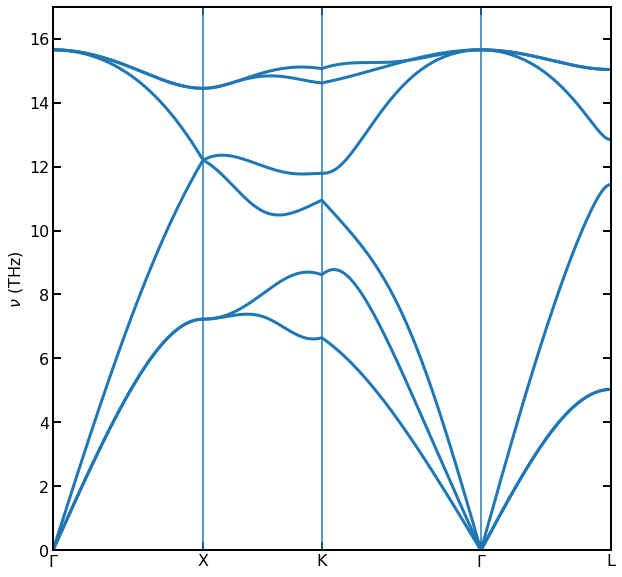

In [9]:
plt.figure(figsize=(10,10))
set_fig_properties(plt.gca())
plt.vlines(sym_points, ymin=0, ymax=17)
plt.plot(linear_path, nu, color='C0',lw=3)
plt.xlim([0, max(linear_path)])
plt.gca().set_xticks(sym_points)
plt.gca().set_xticklabels([r'$\Gamma$','X', 'K', r'$\Gamma$', 'L'])
plt.ylim([0, 17])
plt.ylabel(r'$\nu$ (THz)')
plt.show()

Phonon dispersion of silicon crystal described by the mini-Tersoff potential.

- The above figure shows the phonon dispersion of silicon crystal described by the mini-Tersoff potential [[Fan 2020]](https://doi.org/10.1088/1361-648X/ab5c5f)

## 4. References
[Fan 2020] Zheyong Fan, Yanzhou Wang, Xiaokun Gu, Ping Qian, Yanjing Su, and Tapio Ala-Nissila, [A minimal Tersoff potential for diamond silicon with improved descriptions of elastic and phonon transport properties](https://doi.org/10.1088/1361-648X/ab5c5f), J. Phys.: Condens. Matter **32** 135901 (2020).